In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from importlib import reload
from time import time 

import numpy as np
import scipy as sc
import pandas as pd
import torch

import gb1
import models
from utils import str2onehot

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams["font.size"] = 12

import seaborn as sns
sns.set_style('whitegrid')

MODEL_PATH = '/data/wongfanc/gb1-models/'

2025-01-08 18:55:54.108838: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-08 18:55:54.108869: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-08 18:55:54.109908: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-08 18:55:54.116212: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-08 18:55:55.750756: W tensorflow/comp

In [6]:
# load training sequences
fname = '/data/wongfanc/gb1-models/gb1-h10-5k-030123-train-idx.npz'
d = np.load(fname)
train_idx = d['train_idx'][: 5000]

df = pd.read_csv('../data/gb1-with-variance.csv')
seq_n = list(df['Variants'].str.lower())
y_n = df['log_fitness'].to_numpy()

trainseq_n = [seq_n[i] for i in train_idx]
ytrain_n = np.array([y_n[i] for i in train_idx])

One-hot encoded sequences to shape = (5000, 4, 21) (0 sec)
4500 training data points with 34.0 positive, 500 validation data points with 5.0 positive.


100%|█████████████████████████████████████████████████████| 71/71 [00:00<00:00, 188.40it/s]


Epoch 0. Train loss: 0.69. Val loss: 0.69. 0 sec.


100%|█████████████████████████████████████████████████████| 71/71 [00:00<00:00, 188.78it/s]


Epoch 1. Train loss: 0.65. Val loss: 0.68. 0 sec.


100%|█████████████████████████████████████████████████████| 71/71 [00:00<00:00, 177.96it/s]


Epoch 2. Train loss: 0.54. Val loss: 0.63. 0 sec.


100%|█████████████████████████████████████████████████████| 71/71 [00:00<00:00, 186.34it/s]


Epoch 3. Train loss: 0.40. Val loss: 0.52. 0 sec.


100%|█████████████████████████████████████████████████████| 71/71 [00:00<00:00, 176.48it/s]


Epoch 4. Train loss: 0.30. Val loss: 0.44. 0 sec.


100%|█████████████████████████████████████████████████████| 71/71 [00:00<00:00, 195.13it/s]


Epoch 5. Train loss: 0.21. Val loss: 0.38. 0 sec.


100%|█████████████████████████████████████████████████████| 71/71 [00:00<00:00, 182.11it/s]


Epoch 6. Train loss: 0.14. Val loss: 0.35. 0 sec.


100%|█████████████████████████████████████████████████████| 71/71 [00:00<00:00, 189.45it/s]


Epoch 7. Train loss: 0.10. Val loss: 0.33. 0 sec.


100%|█████████████████████████████████████████████████████| 71/71 [00:00<00:00, 192.10it/s]


Epoch 8. Train loss: 0.08. Val loss: 0.34. 0 sec.


100%|█████████████████████████████████████████████████████| 71/71 [00:00<00:00, 191.82it/s]


Epoch 9. Train loss: 0.07. Val loss: 0.37. 0 sec.


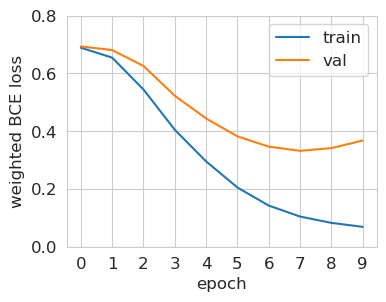

In [27]:
reload(models)
exceedance_threshold = 1.1
n_epoch = 10

predictor = models.FeedForwardClassifier(
    exceedance_threshold,
    4,
    gb1.AA,
    10,
    n_model=3,
    device=torch.device(0)
)
loss_tx2 = predictor.fit(trainseq_n, ytrain_n, n_epoch=n_epoch)

plt.figure(figsize=(4, 3))
plt.plot(loss_tx2[:, 0])
plt.plot(loss_tx2[:, 1])
plt.xticks(range(n_epoch))
plt.ylim([0, 0.8])
plt.xlabel('epoch');
plt.ylabel('weighted BCE loss');
plt.legend(['train', 'val']);

In [19]:
# load design distributions
temperatures = np.arange(0.2, 0.701, 0.005)  # np.arange(0.2, 0.701, 0.005) in 03.08 results
temp2theta = {
    round(t, 4): np.load('/data/wongfanc/gb1-models/gb1-h10-5k-t{:.4f}-030123.npz'.format(t))['theta_lxa']
    for t in temperatures
}

# true means of design distributions
# temp2mean = gb1.get_true_mean_label_from_theta(temp2theta, verbose=True)
# print('Max achievable mean label: {:.4f}'.format(np.max(list(temp2mean.values()))))

In [22]:
# oh.
np.mean(ytrain_n >= exceedance_threshold)

0.0078

In [20]:
# 12.19.24: nope not doing this with binary classifier
reload(models)
reload(gb1)

target_values = np.arange(0.0, 1.01, 0.02)
n_cal = 5000
n_trial = 500
pp_csv_fname = '/data/wongfanc/gb1-results/gb1-pp-exceed{:.4f}-121924.csv'.format(exceedance_threshold)
save_design_samples = False
load_design_samples = True

design_samples_fname_prefix = 'gb1-h10-5k-030123-samples'

df = gb1.run_pp_exceedance_selection_experiments(
    predictor,
    exceedance_threshold,
    temp2theta,
    target_values,
    n_cal=n_cal,
    n_trial=n_trial,
    pp_csv_fname=pp_csv_fname,
    design_samples_fname_prefix=design_samples_fname_prefix,
    load_design_samples=True
)

Selection quantity is probability of exceeding 1.1.
Range of provided target values: [0.000, 1.000].

Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-5k-030123-samples-t0.2000.npz.



KeyboardInterrupt



# 01.08.25